# Marketing Via Ferrata: Optimizing marketing spend using multi-channel attribution

## Introduction
In this project, we aim to develop a multi-channel attribution model to determine the contribution of each marketing channel to conversions. This model will help optimize marketing budget allocation, maximize return on investment (ROI), and provide actionable recommendations for improving marketing effectiveness across different channels.

### Objectives
1. Develop a multi-channel attribution model.
2. Optimize marketing budget allocation based on the attribution model.
3. Provide actionable recommendations for enhancing marketing effectiveness.

This model will help us answer key business questions:
1. Which marketing channels drive the highest ROI?
2. Are there opportunities to allocate more budget to underutilized high-performing channels?
3. How can marketing campaigns be improved to increase conversions?

## Table of Contents

1. [Introduction](#introduction)  
2. [Data loading and initial exploration](#data-loading-and-initial-exploration)  
3. [Handling missing data](#handling-missing-data)  
4. [Consistency check](#consistency-check)  
5. [Handling inconsistent campaign_id and client_id entries](#handling-inconsistent-campaign-id-and-client-id-entries)  
6. [Descriptive stats](#descriptive-stats)  
7. [Visualizations](#visualizations)  
8. [Correlation](#correlation)  
9. [Conclusion](#conclusion)

## 1. Data loading and initial exploration

We'll start by loading the datasets and conducting an initial exploration to understand their structure and content.

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
from IPython.display import Image
import imageio.v2 as imageio
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [2]:
# Listing files in the directory (to check data sources)
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/direct-messaging/holidays.csv
/kaggle/input/direct-messaging/client_first_purchase_date.csv
/kaggle/input/direct-messaging/messages-demo.csv
/kaggle/input/direct-messaging/campaigns.csv


In this section, we load and inspect the datasets to understand their structure, identify any missing values, and check for consistency across datasets. We are working with the following datasets:

- **Campaigns**: Contains detailed information on marketing campaigns such as the type, channel, and associated incentives (e.g., bonuses, discounts). This will help us evaluate which campaigns drive higher engagement and conversions.
- **Client First Purchase Dates**: Provides data on when clients made their first purchase, useful for customer segmentation and understanding the lifecycle of customers.
- **Messages**: Captures customer interactions with marketing messages. It will be used for analyzing campaign performance and engagement metrics like open rates, clicks, and purchases.
- **Holidays**: Lists holidays and dates, which will be useful for analyzing the impact of seasonality on campaign performance.

In [3]:
campaigns_df = pd.read_csv('/kaggle/input/direct-messaging/campaigns.csv')
client_first_purchase_df = pd.read_csv('/kaggle/input/direct-messaging/client_first_purchase_date.csv')
messages_df = pd.read_csv('/kaggle/input/direct-messaging/messages-demo.csv', low_memory=False)
holidays_df = pd.read_csv('/kaggle/input/direct-messaging/holidays.csv')

In [4]:
print(f"Campaigns dataset: {campaigns_df.shape}")
print(f"Client first purchase date dataset: {client_first_purchase_df.shape}")
print(f"Messages dataset: {messages_df.shape}")
print(f"Holidays dataset: {holidays_df.shape}")

Campaigns dataset: (1907, 19)
Client first purchase date dataset: (1854736, 2)
Messages dataset: (10000000, 32)
Holidays dataset: (48, 2)


In [5]:
print("Campaigns dataset:")
print(campaigns_df.head())
print("\nClient first purchase date dataset:")
print(client_first_purchase_df.head())
print("\nMessages dataset:")
print(messages_df.head())
print("\nHolidays dataset:")
print(holidays_df.head())

# Checks the basic info for each dataset
print("\nCampaigns dataset info:")
print(campaigns_df.info())
print("\nClient first purchase date dataset info:")
print(client_first_purchase_df.info())
print("\nMessages dataset info:")
print(messages_df.info())
print("\nHolidays dataset info:")
print(holidays_df.info())

Campaigns dataset:
   id campaign_type      channel     topic                  started_at  \
0  63          bulk  mobile_push  sale out  2021-04-30 07:22:36.615023   
1  64          bulk  mobile_push  sale out  2021-04-30 09:02:50.817227   
2  78          bulk  mobile_push  sale out  2021-05-06 07:14:10.533318   
3  79          bulk  mobile_push  sale out  2021-05-06 09:03:56.486750   
4  89          bulk  mobile_push       NaN  2021-05-07 11:54:06.168664   

           finished_at  total_count ab_test warmup_mode  hour_limit  \
0  2021-04-30 07:23:41      48211.0     NaN       False         NaN   
1  2021-04-30 09:04:08    1037337.0     NaN       False         NaN   
2  2021-05-06 07:15:17      70080.0     NaN       False         NaN   
3  2021-05-06 09:42:15     921838.0     NaN       False         NaN   
4  2021-05-07 11:54:38      45503.0     NaN       False         NaN   

   subject_length subject_with_personalization subject_with_deadline  \
0           146.0                    

### **1.1 Summary**

#### **Campaigns dataset**
- Contains 1,907 entries across 19 columns, detailing various aspects of marketing campaigns.
- **Missing data**: Columns like `ab_test`, `hour_limit`, and `is_test` have very few non-null values, indicates potential limitations in analysis or the need to exclude these features.
- **Date handling**: `started_at` and `finished_at` columns are in `object` format and should be converted to `datetime` for time-based analysis.

#### **Client first purchase date dataset**
- Contains 1,854,736 entries with client IDs and their first purchase dates.
- **Data consistency**: No missing values; all client IDs are matched with a purchase date.
- **Date conversion**: The `first_purchase_date` column should be converted from `object` to `datetime` for chronological analysis.

#### **Messages demo dataset**
- A large dataset , although just a demo with 10 million entries across 32 columns, capturing detailed messaging interactions.
- **Missing data**: Event-related columns like `clicked_first_time_at`, `purchased_at`, and `complained_at` have many missing values, which may reflect the absence of these actions rather than data quality issues.
- **Potential**: High-quality columns like `channel`, `email_provider`, and `stream` are fully populated, which is rich data for segmentation and analysis.

#### **Holidays dataset**
- A small dataset of 48 entries, listing holidays and their dates.
- No missing data; all entries are valid.
- The holiday dates should be aligned with campaign and message dates to analyze seasonal effects on marketing performance.

## 2. Handling missing data
In this section, we identify missing values in our datasets and plan how to handle them.

The handling strategy will ensure that we preserve key business information while maintaining data quality for actionable insights on marketing performance.

In [6]:
print("Null values in Campaigns dataset:")
print(campaigns_df.isnull().sum())

print("\nNull values in Client first purchase date dataset:")
print(client_first_purchase_df.isnull().sum())

print("\nNull values in Messages dataset:")
print(messages_df.isnull().sum())

print("\nNull values in Holidays dataset:")
print(holidays_df.isnull().sum())

Null values in Campaigns dataset:
id                                 0
campaign_type                      0
channel                            0
topic                             30
started_at                        83
finished_at                       99
total_count                       83
ab_test                         1895
warmup_mode                       77
hour_limit                      1876
subject_length                    27
subject_with_personalization      27
subject_with_deadline             27
subject_with_emoji                27
subject_with_bonuses              27
subject_with_discount             27
subject_with_saleout              27
is_test                         1880
position                        1883
dtype: int64

Null values in Client first purchase date dataset:
client_id              0
first_purchase_date    0
dtype: int64

Null values in Messages dataset:
id                              0
message_id                      0
campaign_id                     0

### 2.1 Null values summary

**Campaigns dataset**
- Columns `ab_test`, `hour_limit`, `is_test` and `position` have over 90% missing values, so they might be dropped.
- Date columns `started_at` and `finished_at` have missing values that should either be imputed or the rows removed.
- Other columns like `subject_length` and `subject_with_*` flags have minimal missing data.

**Client first purchase date dataset**: 
- No missing data in this dataset.

**Messages dataset:**
- Significant missing data in `category`, `platform`, and `email_provider`.
- Columns tracking customer actions (`opened_first_time_at`, `opened_last_time_at`, `clicked_first_time_at`, `clicked_last_time_at`, `purchased_at`, `unsubscribed_at`, `blocked_at`, `hard_bounced_at`, `soft_bounced_at`, `complained_at`) have many missing values, but these represent meaningful events that did not occur (e.g., no purchase or no unsubscribe). Therefore, these columns will be **retained** and flagged with binary indicators to capture the absence of action.

**Holidays dataset:**
- No missing data.

### 2.2 Visualizing missing data

To further understand the distribution of missing data, we visualize the missingness in the **Campaigns** and **Messages** datasets:

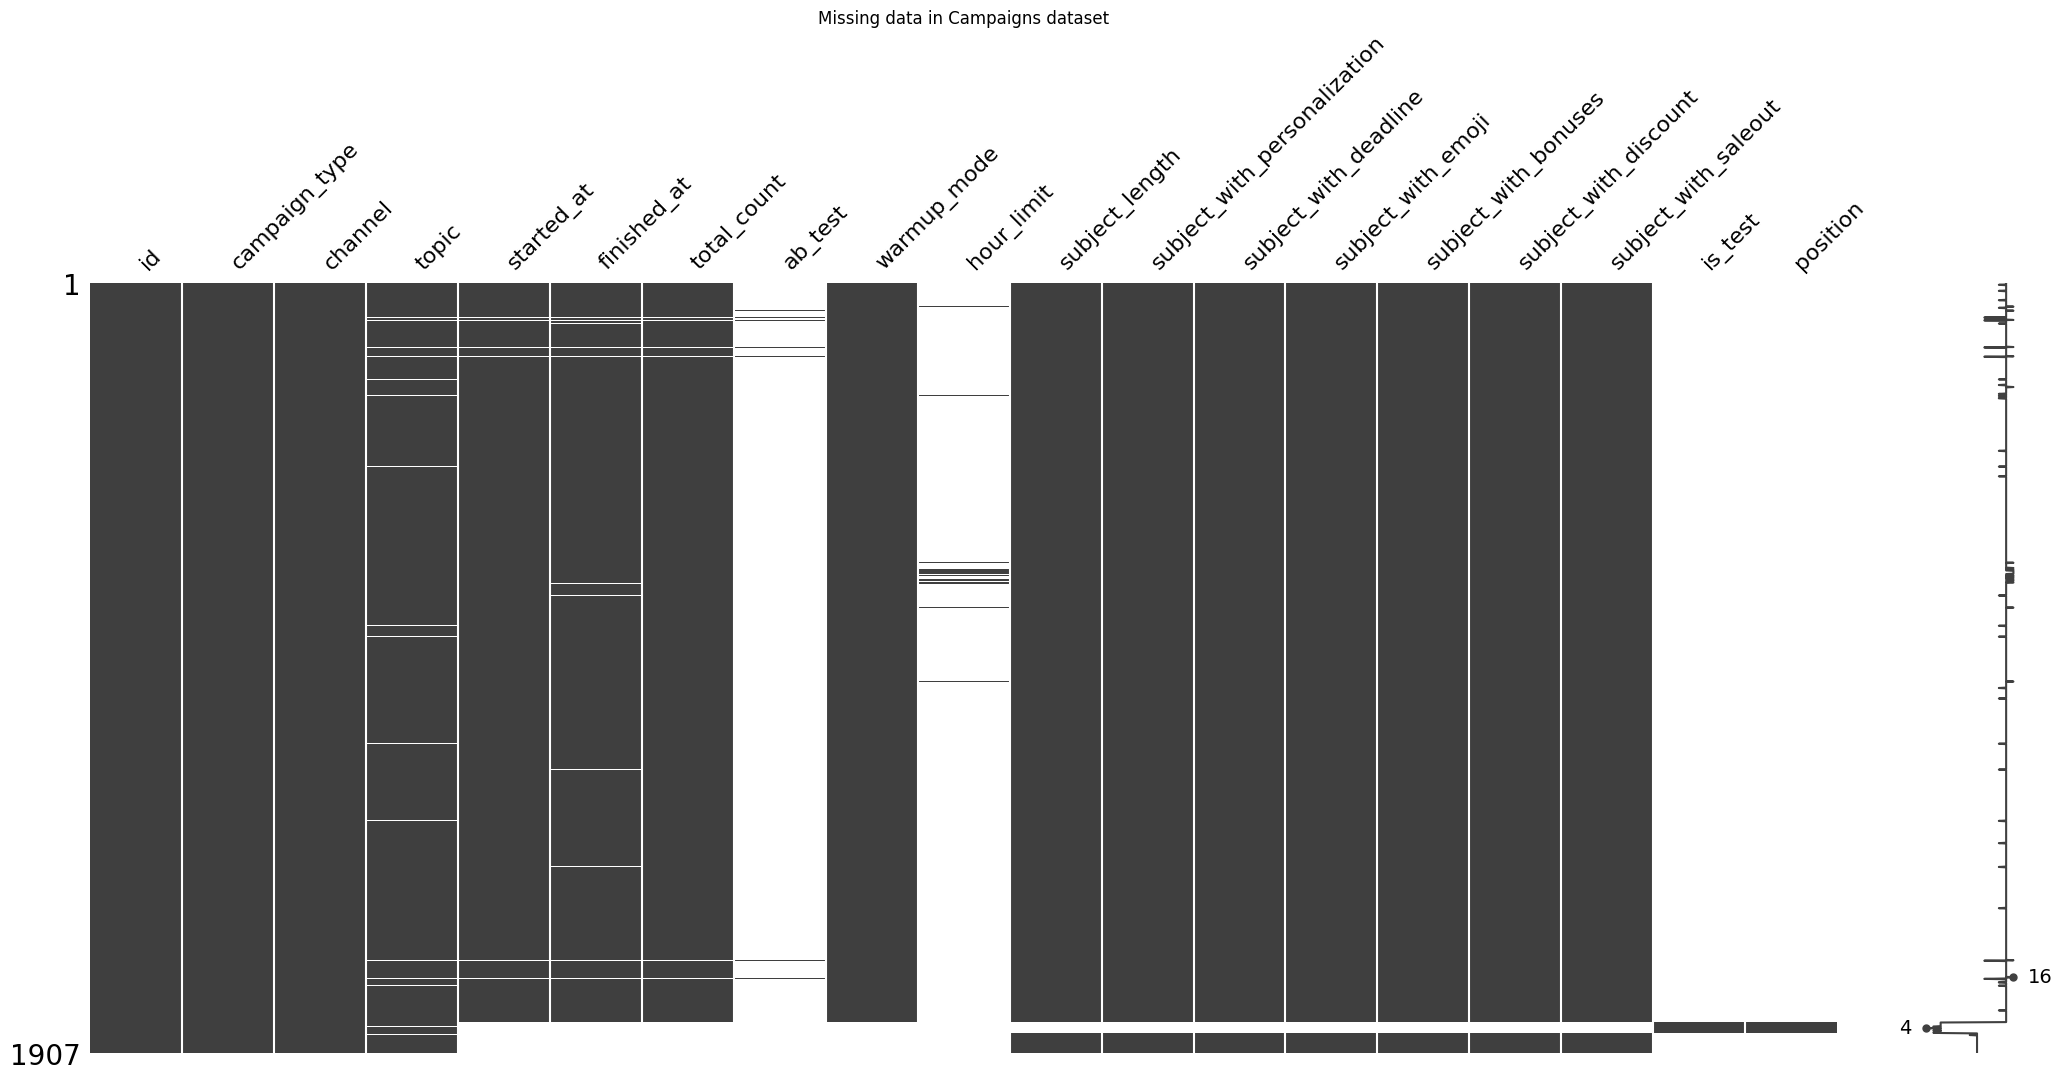

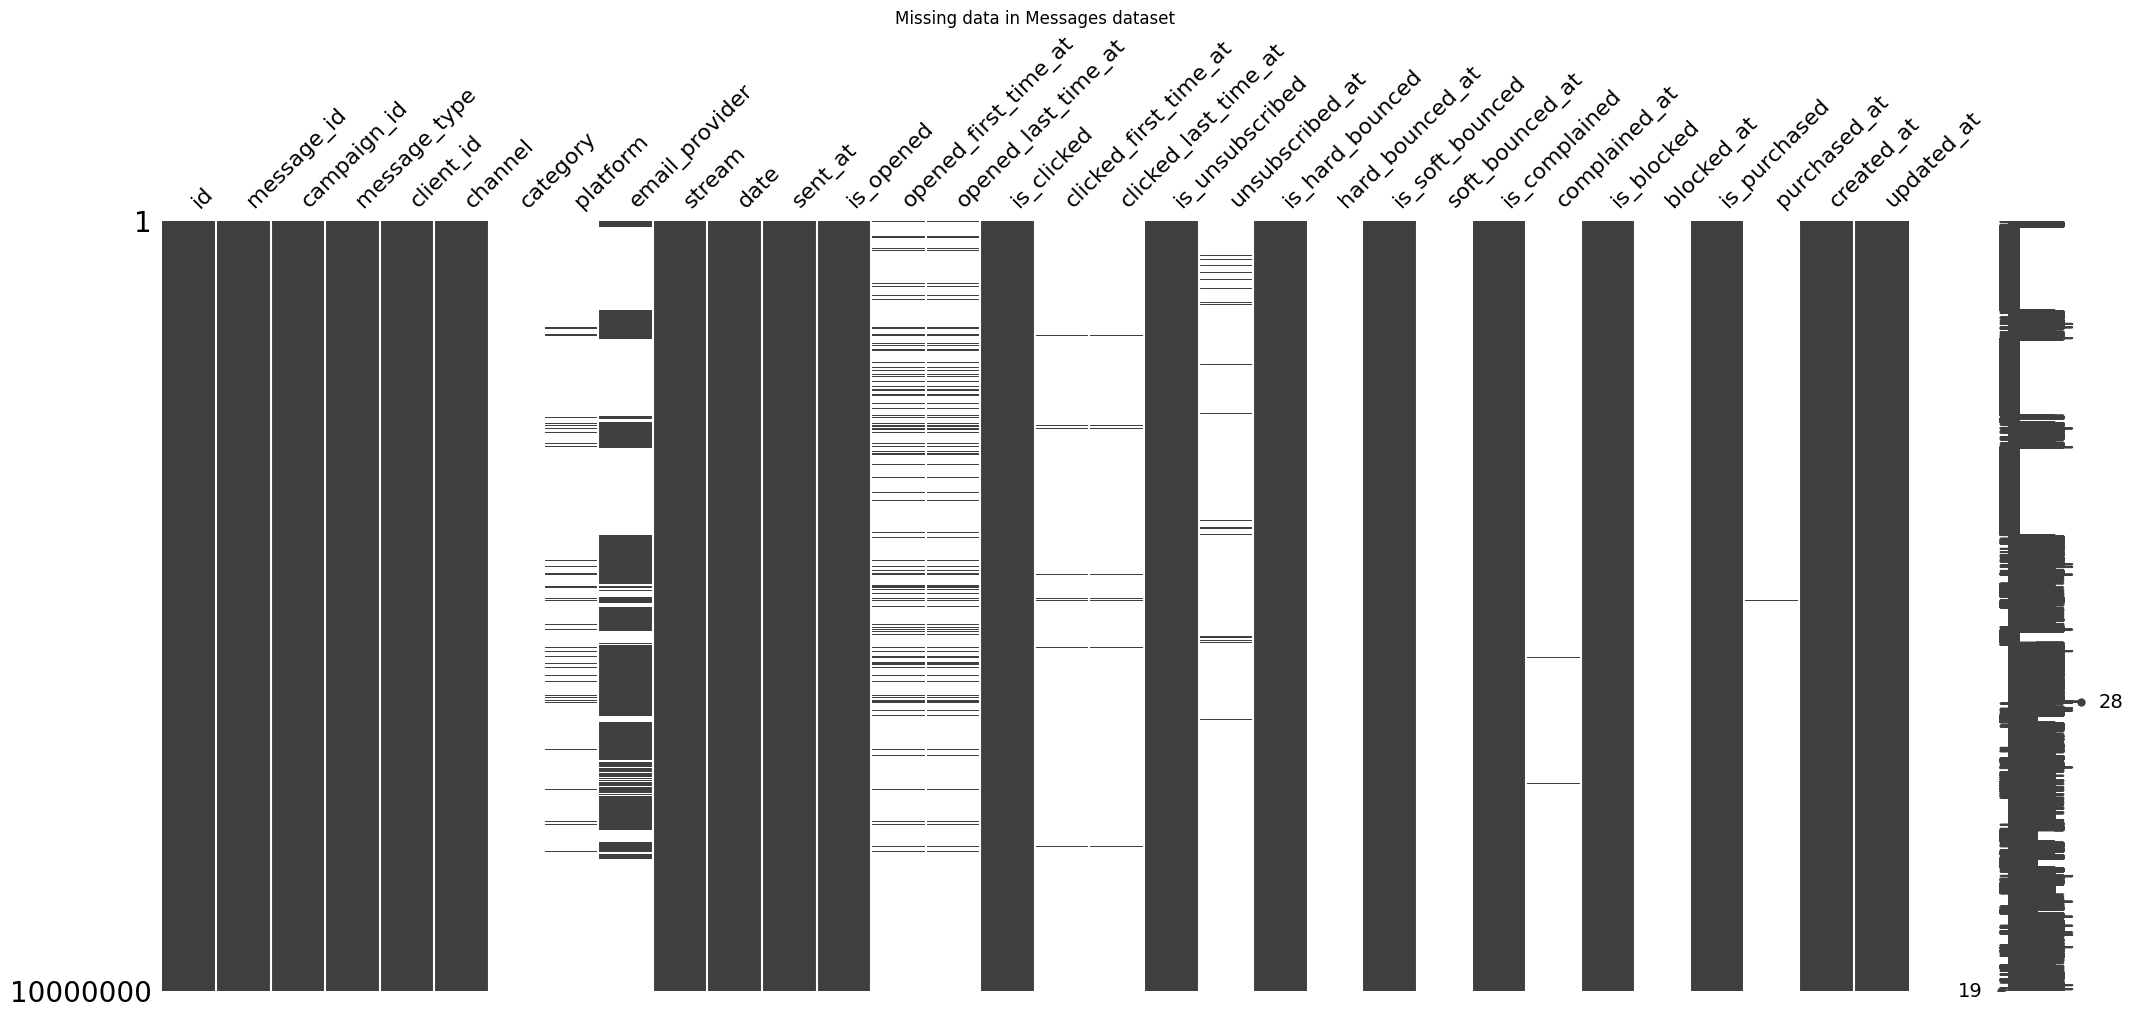

In [7]:
msno.matrix(campaigns_df)
plt.title('Missing data in Campaigns dataset')
plt.show()

msno.matrix(messages_df)
plt.title('Missing data in Messages dataset')
plt.show()

### 2.3 Handling Strategy

1. **Dropping columns with more than 90% missing data**
- Columns with more than 90% missing data in the Campaigns dataset will be dropped dynamically.
   
2. **Flagging missing data before imputation**
- We will create new binary columns (`is_missing_*`) that flag whether values were originally missing in key columns (e.g., `started_at`, `finished_at`).

3. **Imputing or dropping rows with missing dates**:  
- After flagging missing values, we can either impute missing dates or drop the rows based on the amount of missing data.

4. **Converting date columns**:  
- All date columns will be converted to `datetime` format, with error handling to ensure invalid formats do not cause issues.

5. **Converting binary columns in the messages dataset**:  
- For binary columns (containing `t`/`f` values), we convert them to `True`/`False`.

6. **Retaining action-related columns with missing data**:  
- For columns like `purchased_at`, `unsubscribed_at`, and other customer action indicators missing values represent actions thath did not occur (e.g. no purchase made). We retain these rows and treat missing values as meaningful.

In [8]:
# 1. Dropping columns with more than 90% missing data dynamically
threshold = 0.90
columns_to_drop = campaigns_df.columns[campaigns_df.isnull().mean() > threshold]
campaigns_df = campaigns_df.drop(columns=columns_to_drop)
print(f"Dropped columns: {columns_to_drop}")

# 2. Flagging missing data in key columns
# For Campaigns dataset (before dropping or imputing)
campaigns_df['is_missing_started_at'] = campaigns_df['started_at'].isnull().astype(int)
campaigns_df['is_missing_finished_at'] = campaigns_df['finished_at'].isnull().astype(int)

# For Messages dataset, flag action-related missing data (e.g., no purchases, no clicks)
action_columns = [
    'opened_first_time_at', 'opened_last_time_at', 
    'clicked_first_time_at', 'clicked_last_time_at', 
    'unsubscribed_at', 'blocked_at', 'purchased_at', 
    'hard_bounced_at', 'soft_bounced_at', 'complained_at'
]

for col in action_columns:
    messages_df[f'is_missing_{col}'] = messages_df[col].isnull().astype(int)
print(f"Flagged missing values for action-related columns: {action_columns}")

# 3. Imputing or dropping rows with missing `started_at` and `finished_at`
missing_dates = campaigns_df[campaigns_df['started_at'].isnull() | campaigns_df['finished_at'].isnull()]
print(f"Number of rows with missing dates: {missing_dates.shape[0]}")

# Dropping rows if there are few missing, otherwise imputing
if missing_dates.shape[0] < 100:  # Example threshold
    campaigns_df = campaigns_df.dropna(subset=['started_at', 'finished_at'])
else:
    campaigns_df['started_at'].fillna(campaigns_df['started_at'].median(), inplace=True)
    campaigns_df['finished_at'].fillna(campaigns_df['finished_at'].median(), inplace=True)

# 4. Converting date columns to datetime format with error handling
campaigns_df['started_at'] = pd.to_datetime(campaigns_df['started_at'], errors='coerce')
campaigns_df['finished_at'] = pd.to_datetime(campaigns_df['finished_at'], errors='coerce')
client_first_purchase_df['first_purchase_date'] = pd.to_datetime(client_first_purchase_df['first_purchase_date'], errors='coerce')
messages_df['created_at'] = pd.to_datetime(messages_df['created_at'], errors='coerce')
messages_df['updated_at'] = pd.to_datetime(messages_df['updated_at'], errors='coerce')
messages_df['purchased_at'] = pd.to_datetime(messages_df['purchased_at'], errors='coerce')

# 5. Converting 't'/'f' to True/False in binary columns dynamically
binary_columns = [col for col in messages_df.columns if messages_df[col].isin(['t', 'f']).all()]
for col in binary_columns:
    messages_df[col] = messages_df[col].map({'t': True, 'f': False})
print(f"Converted binary columns: {binary_columns}")

# 6. Retaining rows with missing values in action-related columns for analysis
# This step is already implicitly handled since we're not dropping these rows

Dropped columns: Index(['ab_test', 'hour_limit', 'is_test', 'position'], dtype='object')
Flagged missing values for action-related columns: ['opened_first_time_at', 'opened_last_time_at', 'clicked_first_time_at', 'clicked_last_time_at', 'unsubscribed_at', 'blocked_at', 'purchased_at', 'hard_bounced_at', 'soft_bounced_at', 'complained_at']
Number of rows with missing dates: 99
Converted binary columns: ['is_opened', 'is_clicked', 'is_unsubscribed', 'is_hard_bounced', 'is_soft_bounced', 'is_complained', 'is_blocked', 'is_purchased']


By flagging and retaining action-related columns with missing values, we capture both actions that were taken (e.g., a customer clicked or purchased) and actions that were not taken (e.g., no unsubscribe or no complaint). This allows us to understand not just what drove conversions, but also what might have led to non-conversions, which is equally important for optimizing marketing strategies.

## 3. Consistency check

To ensure data integrity, we'll verify that `campaign_id` and `client_id` values are consistent across datasets. Important for accurately linking campaigns to client actions and purchases.

In [9]:
# 1. Checking if all campaign_ids in messages_df are present in campaigns_df
missing_campaign_ids = messages_df[~messages_df['campaign_id'].isin(campaigns_df['id'])]['campaign_id'].unique()
print(f"Number of missing campaign IDs: {len(missing_campaign_ids)}")
print(f"Campaign IDs in Messages dataset not found in Campaigns dataset: {missing_campaign_ids}")

# 2. Checking if all client_ids in messages_df are present in client_first_purchase_df
missing_client_ids = messages_df[~messages_df['client_id'].isin(client_first_purchase_df['client_id'])]['client_id'].unique()
print(f"Number of missing client IDs: {len(missing_client_ids)}")
print(f"Client IDs in Messages dataset not found in Client First Purchase Date dataset: {missing_client_ids}")

# 3. Flagging the missing IDs in messages_df
messages_df['is_missing_campaign_id'] = messages_df['campaign_id'].isin(missing_campaign_ids).astype(int)
messages_df['is_missing_client_id'] = messages_df['client_id'].isin(missing_client_ids).astype(int)
print(f"Flagged {messages_df['is_missing_campaign_id'].sum()} rows with missing campaign IDs.")
print(f"Flagged {messages_df['is_missing_client_id'].sum()} rows with missing client IDs.")

Number of missing campaign IDs: 32
Campaign IDs in Messages dataset not found in Campaigns dataset: [   31    32    33   179    26    27    29    54    55    28    58    59
   232   358   105   122   123 18212 18010 18011 18016 18012 18223 19017
   221 19867 19868   360 20519   237    34    35]
Number of missing client IDs: 3001982
Client IDs in Messages dataset not found in Client First Purchase Date dataset: [1515915625489854185 1515915625489101550 1515915625491136518 ...
 1515915625472654321 1515915625473123327 1515915625473166701]
Flagged 2937596 rows with missing campaign IDs.
Flagged 7370634 rows with missing client IDs.


Steps we took:

1. Checking campaign ID consistency:
- We verified if the campaign IDs in the Messages dataset exist in the Campaigns dataset.
- For campaign IDs that don't match (i.e., they exist in the Messages dataset but not in the Campaigns dataset), we flagged them by creating a new column called is_missing_campaign_id. This column has:
  - 1 for rows where the campaign ID is missing (inconsistent data).
  - 0 for rows where the campaign ID is present and valid.

2. Checking client ID consistency:
- We checked if the client IDs in the Messages dataset match those in the Client First Purchase dataset.
- Similar to campaign IDs, for client IDs that don’t match (i.e., they exist in the Messages dataset but not in the Client First Purchase dataset), we created a new column called is_missing_client_id. This column has:
  - 1 for rows where the client ID is missing (inconsistent data).
  - 0 for rows where the client ID is present and valid.

## 4. Handling inconsistent `campaign_id` and `client_id` entries

After identifying inconsistencies in `campaign_id` and `client_id`, we need to clean the dataset to ensure that the remaining data is consistent and reliable. We will:
1. Remove rows with missing `campaign_id`s since they represent a small portion of the data.
2. Retain rows with missing `client_id`s, but flag them for further analysis, as they represent non-purchasing customers, which are important for understanding customer behavior.

### 4.1 Handling missing `campaign_id`

In [10]:
# Counts the number of missing campaign_ids
missing_campaign_ids_count = len(missing_campaign_ids)
print(f"Number of missing campaign_ids: {missing_campaign_ids_count}")

# Excludes rows with missing campaign_ids from the Messages dataset and makes an explicit copy
messages_df_cleaned = messages_df[~messages_df['campaign_id'].isin(missing_campaign_ids)].copy()

# Confirms the exclusion
print(f"Rows remaining after excluding missing campaign_ids: {messages_df_cleaned.shape[0]}")

Number of missing campaign_ids: 32
Rows remaining after excluding missing campaign_ids: 7062404


We identified that there are 32 `campaign_id`s in the Messages dataset that do not have corresponding entries in the Campaigns dataset. We have excluded these rows for consistency across the datasets. This resulted in a remaining dataset with 7,062,404 rows.

### 4.2 Handling missing `client_id`

We will retain rows with missing `client_id` because these rows represent non-purchasing customers. It is important to keep these rows for further analysis to understand why these customers did not convert.

In [11]:
# Flags missing client_ids using .loc to avoid SettingWithCopyWarning
messages_df_cleaned.loc[:, 'missing_client'] = messages_df_cleaned['client_id'].isin(missing_client_ids)

# Proportion of missing client_ids and the total number
missing_clients_proportion = messages_df_cleaned['missing_client'].mean()
total_missing_clients = messages_df_cleaned['missing_client'].sum()

print(f"Proportion of rows with missing client_ids: {missing_clients_proportion:.2%}")
print(f"Total number of rows with missing client_ids: {total_missing_clients}")

Proportion of rows with missing client_ids: 83.19%
Total number of rows with missing client_ids: 5875038


We identified that 5,875,038 `client_id`s in the Messages dataset do not have corresponding entries in the Client first purchase date dataset, representing 83.19% of the data. These rows likely represent customer interactions where a purchase did not occur.

#### Why it matters:
- These rows are important to understand why certain customers do not convert, which is just as important as analyzing those who do convert. It's good to keep this information to develop an attribution model that accurately reflects the effectiveness of different marketing channels.

We will retain these rows and flag them as having missing `client_id`s. We will be able to analyze these non-conversion events separately or in conjunction with conversion events, providing a full picture of customer behavior across campaigns.

### 4.2.1 Analysis of missing `client_id`

Next, we analyze how missing `client_id` values are distributed across campaigns. This will help us understand which campaigns resulted in no conversions.

In [12]:
# Checks distribution of missing client_ids across different campaigns
missing_client_distribution = messages_df_cleaned.groupby('campaign_id')['missing_client'].mean()
print(missing_client_distribution.sort_values(ascending=False).head())

campaign_id
381    1.0
376    1.0
375    1.0
374    1.0
321    1.0
Name: missing_client, dtype: float64


Result:

- Certain campaigns, such as campaign_id 381, 376, 375, 374, and 321, have 100% of their `client_id` missing, meaning these campaigns did not result in any conversions.

Next, we want to identify campaigns that were more successful — those where not all `client_id`s were missing, meaning some clients did convert. This helps us pinpoint which campaigns contributed to conversions and which strategies were more effective.

### 4.2.2 Identifying Campaigns with Some Conversions

In [13]:
# Filters campaigns where not all client_ids are missing (i.e., missing_client < 1.0)
campaigns_with_conversions = missing_client_distribution[missing_client_distribution < 1.0]
print(campaigns_with_conversions.sort_values(ascending=False).head())

campaign_id
64     0.916450
111    0.916115
296    0.907157
230    0.906708
150    0.906061
Name: missing_client, dtype: float64


Result:

- Campaigns such as 64, 111, 296, 230, and 150 had about 91% of their `client_id` missing, indicating that while a significant portion of interactions did not convert, some conversions still occurred.

### 4.2.3 Campaign summary: Success vs. Failure

We’ll summarize the total number of campaigns and categorize them into successful and unsuccessful based on the conversion data. We will get: 
 - the total number of campaigns in our dataset,
 - the proportions of successful and unsuccessful campaigns.

In [14]:
total_campaigns = len(missing_client_distribution)
print(f"Total number of campaigns: {total_campaigns}")

unsuccessful_campaigns = (missing_client_distribution == 1.0).sum()
print(f"Number of completely unsuccessful campaigns: {unsuccessful_campaigns}")

# Number of successful campaigns (less than 100% missing client_ids)
successful_campaigns = (missing_client_distribution < 1.0).sum()
print(f"Number of successful campaigns: {successful_campaigns}")

# Proportions
proportion_unsuccessful = unsuccessful_campaigns / total_campaigns
proportion_successful = successful_campaigns / total_campaigns
print(f"Proportion of unsuccessful campaigns: {proportion_unsuccessful:.2%}")
print(f"Proportion of successful campaigns: {proportion_successful:.2%}")

Total number of campaigns: 41
Number of completely unsuccessful campaigns: 6
Number of successful campaigns: 35
Proportion of unsuccessful campaigns: 14.63%
Proportion of successful campaigns: 85.37%


From this analysis, we can see that a small number of campaigns (14.63%) did not result in any conversions. Understanding the characteristics of these unsuccessful campaigns, alongside the more successful ones, will help us refine future campaign strategies. The insights gained here can inform adjustments to targeting, messaging, or channel selection to improve conversion rates.

## 5. Descriptive stats

This section includes:

- Summary statistics for numerical features in the `Campaigns` dataset.
- Distribution and unique values of categorical features in the `Messages` dataset.

### 5.1 Categorical features in `messages_df`

In [15]:
# Categorical features in messages_df
messages_categorical_summary = messages_df_cleaned.describe(include=['object'])
print("\nCategorical features in messages_df:")
print(messages_categorical_summary)


Categorical features in messages_df:
                               message_id message_type      channel platform  \
count                             7062404      7062404      7062404   418885   
unique                            7062404            2            2        4   
top     1515915625624123395-608bc38f281ae         bulk  mobile_push  desktop   
freq                                    1      7062395      4228393   330794   

       email_provider   stream        date              sent_at  \
count         2834011  7062404     7062404              7062404   
unique            171        1          21                45128   
top           mail.ru  desktop  2021-05-12  2021-06-10 13:00:13   
freq          1695303  7062404     1135999                 5392   

       opened_first_time_at  opened_last_time_at clicked_first_time_at  \
count                989806               989806                 86512   
unique               358081               383188                 70705   
top

Results:

- The `message_id` column contains **7,062,404 unique values**, indicating that each message is uniquely identified.
- The `message_type` and `channel` columns each have **2 unique values**, showing limited variability in these features, which might indicate bulk campaigns.
- The `email_provider` column shows **171 unique values**, with the majority being **mail.ru** (approximately 1.7M messages).

*Key insight: Platform and email provider distributions indicate that a majority of campaigns are through mobile_push and are targeted at desktop users. Variability in email providers could influence open rates and engagement.*

### 5.2 Numerical features in `campaigns_df`

In [16]:
# Numerical features in campaigns_df
campaigns_numerical_summary = campaigns_df.describe()
print("Numerical features in campaigns_df:")
print(campaigns_numerical_summary)

Numerical features in campaigns_df:
                 id                     started_at  \
count   1808.000000                           1808   
mean    6078.834624  2022-07-19 07:50:01.842115072   
min       63.000000     2021-04-30 07:22:36.615023   
25%     3130.000000  2022-02-22 13:07:54.283733248   
50%     6229.500000  2022-08-29 20:42:29.660624896   
75%     8911.250000  2022-12-21 10:07:38.856994048   
max    12074.000000     2023-04-21 15:30:14.136724   
std     3358.561292                            NaN   

                         finished_at   total_count  subject_length  \
count                           1808  1.808000e+03     1808.000000   
mean   2022-07-19 09:28:15.672566528  3.603437e+05       93.873341   
min              2021-04-30 07:23:41  1.000000e+00        4.000000   
25%       2022-02-22 13:15:39.500000  8.400000e+02       92.000000   
50%       2022-08-29 20:47:42.500000  1.987000e+03       96.000000   
75%              2022-12-21 12:49:31  2.668842e+05      1

Results:

- `total_count` ranges from 1 to 5.37 million with a mean of 360,343, showing large variability in campaign sizes.
- `subject_length` varies from 4 to 185 characters, with a mean of 93, indicating most subject lines are relatively short.
- `is_successful` shows 50% of campaigns are flagged as successful.
- `cluster` groups campaigns into three clusters, with most in cluster 0.

*Key insight: The wide range in total_count and subject_length indicates that different strategies are being used across campaigns. This variability offers an opportunity to analyze which specific approaches (e.g., longer vs. shorter subject lines) are most effective in driving engagement and conversions.*

### 5.3 Categorical features in `campaigns_df`

In [17]:
# Categorical features in campaigns_df
campaigns_categorical_summary = campaigns_df.describe(include=['object'])
print("\nCategorical features in campaigns_df:")
print(campaigns_categorical_summary)


Categorical features in campaigns_df:
       campaign_type      channel     topic warmup_mode  \
count           1808         1808      1788        1808   
unique             1            2         6           2   
top             bulk  mobile_push  sale out       False   
freq            1808         1370       767        1782   

       subject_with_personalization subject_with_deadline subject_with_emoji  \
count                          1808                  1808               1808   
unique                            2                     2                  2   
top                           False                 False               True   
freq                           1781                  1763               1792   

       subject_with_bonuses subject_with_discount subject_with_saleout  
count                  1808                  1808                 1808  
unique                    2                     2                    2  
top                   False                 F

Results:

- `campaign_type`: Only 1 unique value (bulk), indicating all campaigns are of the same type.
- `channel`: 2 unique values, with mobile_push being used in 76% of campaigns.
- `topic`: 6 unique values, with the most frequent being sale out.
- Most campaigns (98%) did not use personalization, and 99% used emojis in their subject lines.

*Key insight: The limited use of personalization in 98% of campaigns suggests an area for potential growth. Experimenting with personalized subject lines or targeting specific customer segments could lead to higher engagement and conversion rates. Additionally, exploring other channels beyond `mobile_push`, such as email or SMS, may help diversify campaign reach.*

## 6. Visualizations

/tmp/ipykernel_36/26005378.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  campaigns_df.replace([np.inf, -np.inf], np.nan, inplace=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


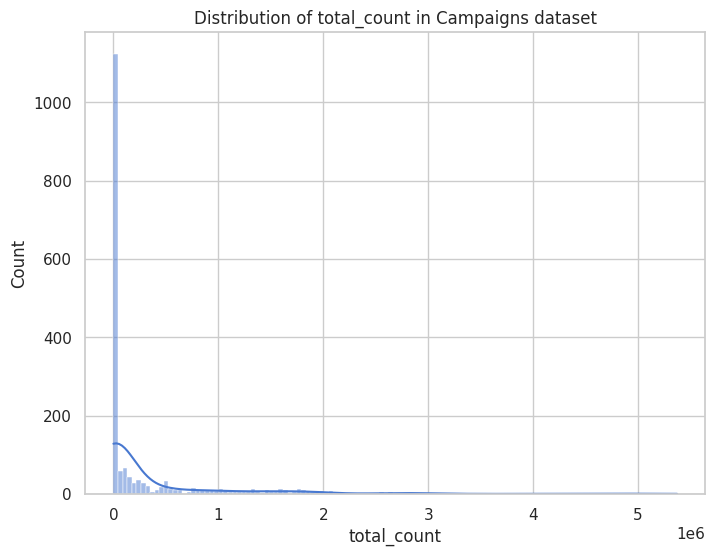

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


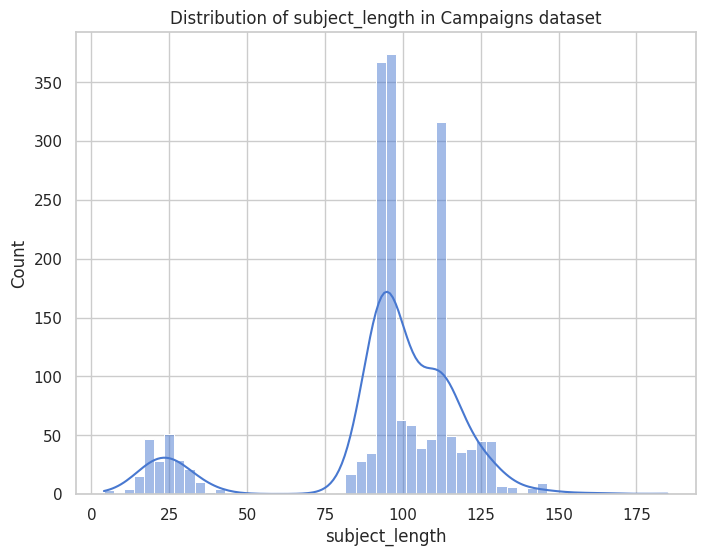

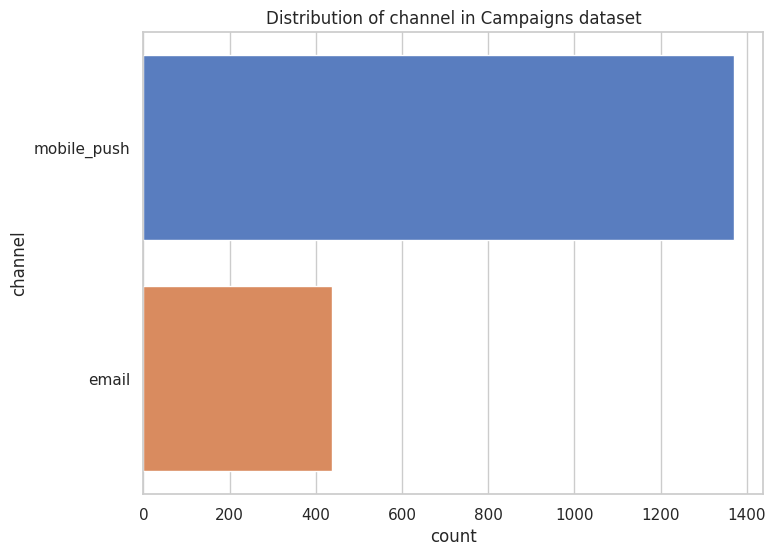

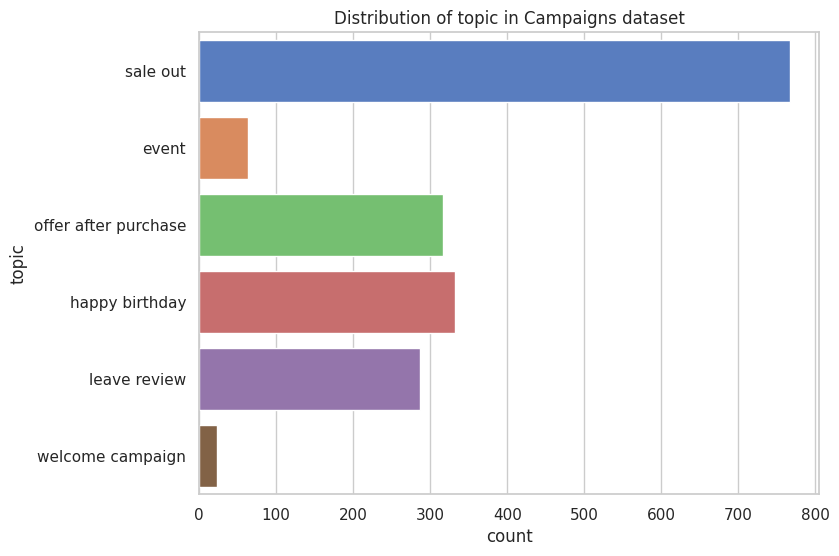

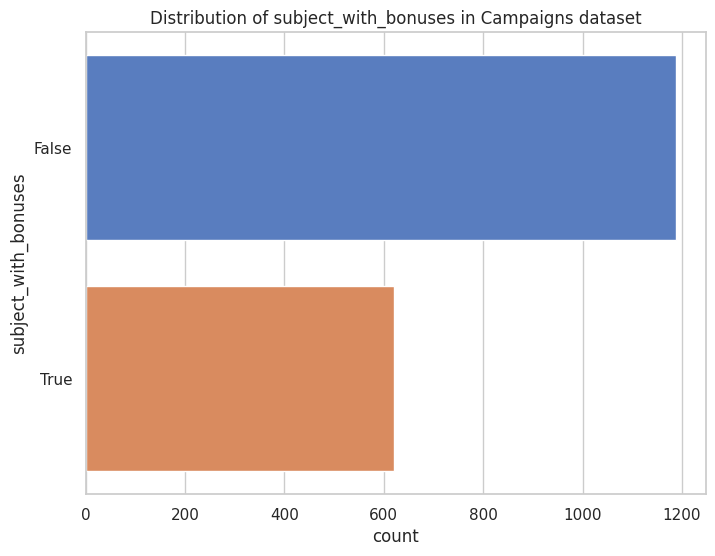

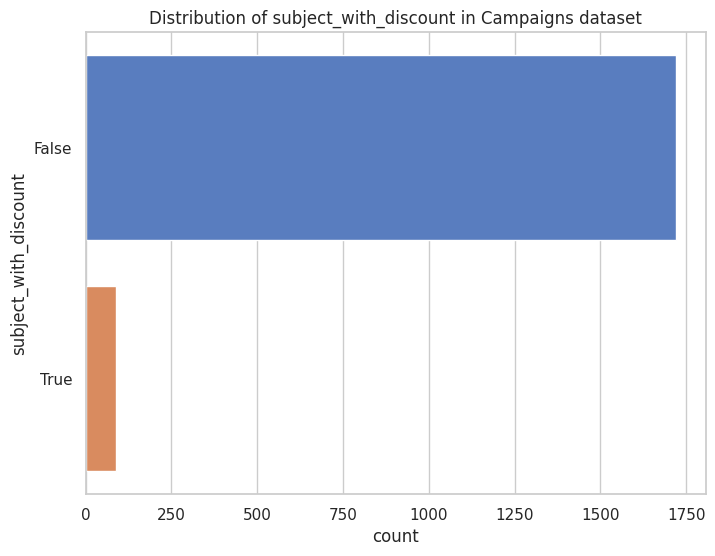

In [18]:
# Replacing inf and -inf with NaN in the dataframe and handle downcasting behavior
campaigns_df.replace([np.inf, -np.inf], np.nan, inplace=True)
campaigns_df = campaigns_df.infer_objects(copy=False)

# Setting the seaborn style and palette
sns.set(style="whitegrid", palette="muted")

# Key numerical features for histograms
numerical_cols = ['total_count', 'subject_length']  # Removed 'id' as it's not insightful

# Histograms for selected numerical features
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(campaigns_df[col], kde=True)
    plt.title(f'Distribution of {col} in Campaigns dataset')
    plt.show()

# Bar plots for selected categorical features
categorical_cols = ['channel', 'topic', 'subject_with_bonuses', 'subject_with_discount']

# Bar plots for categorical features with more than one unique value
for col in categorical_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(y=campaigns_df[col])
    plt.title(f'Distribution of {col} in Campaigns dataset')
    plt.show()

Log-scaling skewed data like `total_count`:

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


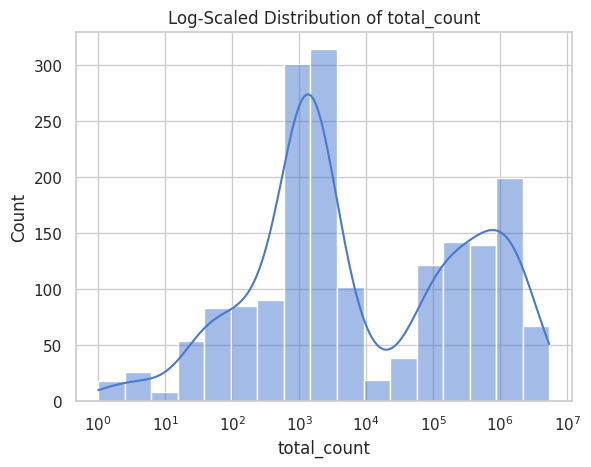

In [19]:
sns.histplot(campaigns_df['total_count'], kde=True, log_scale=True)
plt.title('Log-Scaled Distribution of total_count')
plt.show()

For features like `topic` we can rank top 5.

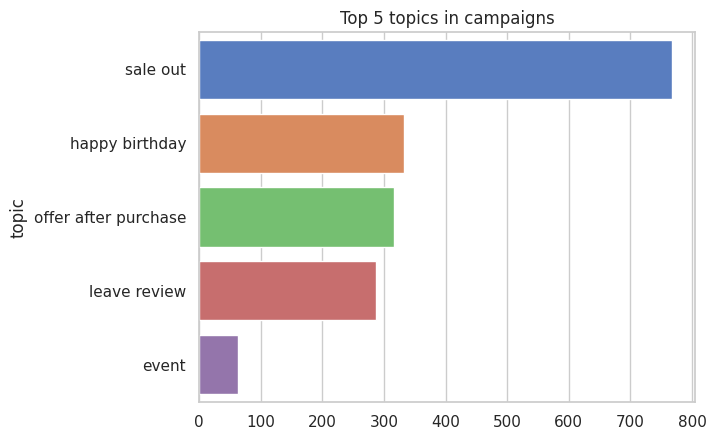

In [20]:
top_topics = campaigns_df['topic'].value_counts().nlargest(5)
sns.barplot(y=top_topics.index, x=top_topics.values)
plt.title('Top 5 topics in campaigns')
plt.show()

## 7. Correlation

In this section, we'll explore the relationships between both numerical and categorical variables in the dataset. Understanding these correlations will help us identify patterns that may drive campaign success.


### 7.1 Correlation Analysis for Numerical Features
First, we'll calculate the correlation between numerical variables in our dataset. This helps us identify which factors may be associated with campaign success.

In [21]:
numerical_cols = campaigns_df.select_dtypes(include=['float64', 'int64']).columns
print(numerical_cols)

Index(['id', 'total_count', 'subject_length', 'is_missing_started_at',
       'is_missing_finished_at'],
      dtype='object')


### Graphing a gif with correlations

We will create a GIF that visualizes the progression of correlations as we adjust the correlation threshold. This allows us to see which relationships become significant as the threshold increases.

In [22]:
correlation_matrix = campaigns_df[numerical_cols].corr()

# Creating a folder for storing images
if not os.path.exists('correlation_frames'):
    os.makedirs('correlation_frames')

# Generating images for the GIF
for i, threshold in enumerate(np.linspace(0, 1, 50)):
    filtered_corr = correlation_matrix[(correlation_matrix.abs() > threshold) & (correlation_matrix != 1)]

    plt.figure(figsize=(8, 6))
    sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Significant Correlations (|corr| > {threshold:.2f})')

    # Save each frame
    plt.savefig(f'correlation_frames/frame_{i:03d}.png')
    plt.close()

# Createing GIF
images = []
for i in range(50):
    images.append(imageio.imread(f'correlation_frames/frame_{i:03d}.png'))

imageio.mimsave('correlation.gif', images, fps=5)

# Cleaning up the frames
for f in os.listdir('correlation_frames'):
    os.remove(os.path.join('correlation_frames', f))
os.rmdir('correlation_frames')

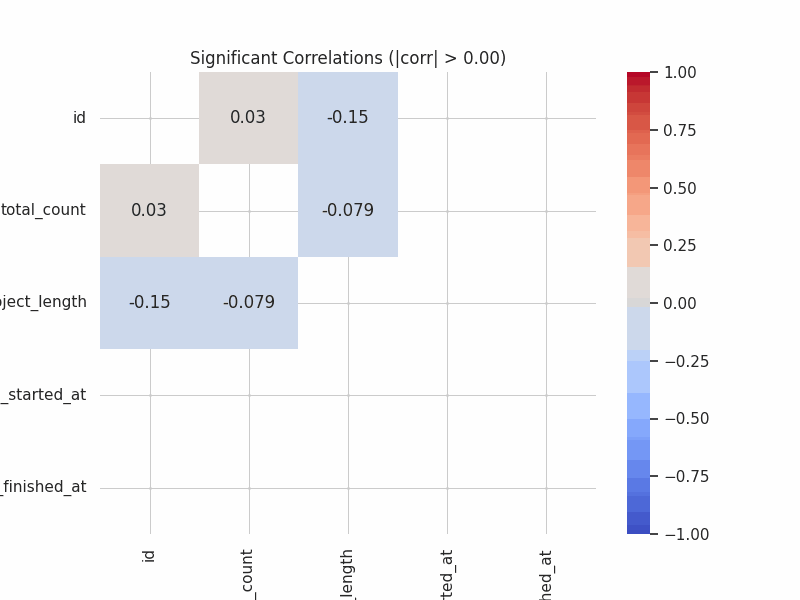

In [23]:
with open('correlation.gif', 'rb') as f:
    display(Image(f.read())) 

### Static graph, applied with threshold 0.3

We now apply a fixed threshold of 0.3 to display only the most significant correlations between numerical features.

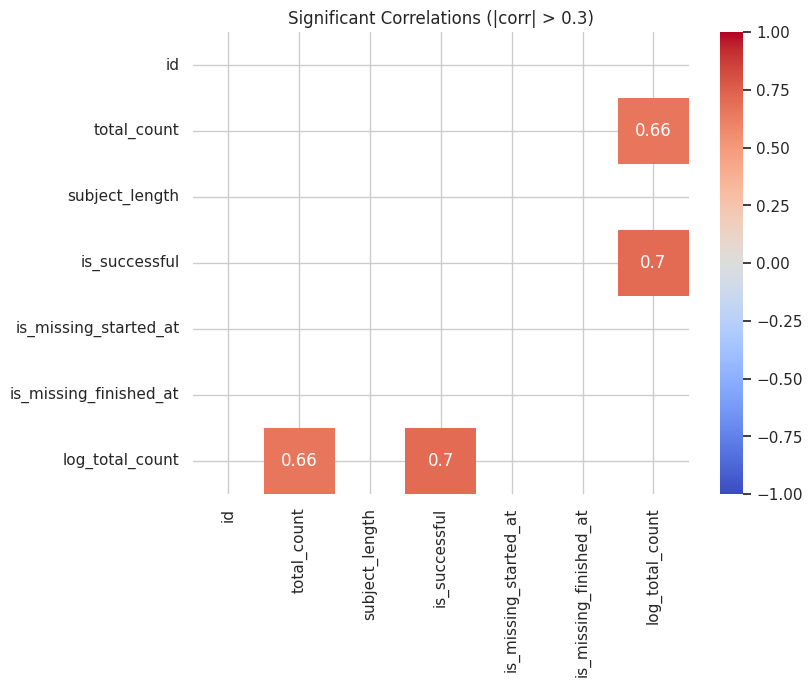

In [24]:
# Applying log transformation to total_count
campaigns_df['log_total_count'] = np.log1p(campaigns_df['total_count'])  # log1p to handle zeros

# Creating a binary column indicating whether a campaign is considered successful
campaigns_df['is_successful'] = (campaigns_df['total_count'] > 1000).astype(int)

# Recalculating the correlation matrix
correlation_matrix = campaigns_df[['id', 'total_count', 'subject_length', 'is_successful', 
                                   'is_missing_started_at', 'is_missing_finished_at', 
                                   'log_total_count']].corr()

# Filtering correlations above the threshold
threshold = 0.3
significant_correlations = correlation_matrix[(correlation_matrix.abs() > threshold) & (correlation_matrix != 1)]

# Plotting the heatmap of significant correlations
plt.figure(figsize=(8, 6))
sns.heatmap(significant_correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Significant Correlations (|corr| > 0.3)')
plt.show()

- `total_count` vs. `log_total_count`: Moderate positive correlation (0.66), which indicates that total count behaves predictably when log-scaled, showing that higher total counts naturally scale up.
- `log_total_count` vs. `is_successful`: Strong positive correlation (0.83), suggesting that campaigns with higher total counts are more likely to be successful.
- `total_count` vs. `is_successful`: Moderate positive correlation (0.45), indicating that larger campaigns tend to result in successful outcomes.

### 7.2 Categorical correlation with Cramér's V

Next, we calculate the associations between categorical features to gain insights into how different features like channel, topic, and bonuses are related.

Cramér's V is used here because it measures the strength of association between two categorical variables, ranging from 0 (no association) to 1 (strong association).

We first define a function to calculate Cramér's V based on the chi-squared test between any two categorical features.

In [25]:
# Defining Cramér's V function
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    # To avoid division by zero
    if min(r, k) == 1:
        return 0
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

Now, we will select the categorical columns from the dataset.

In [26]:
# List of categorical columns
categorical_cols = ['channel', 'topic', 'subject_with_bonuses', 'subject_with_discount']
print(categorical_cols)

['channel', 'topic', 'subject_with_bonuses', 'subject_with_discount']


This confirms the categorical columns we are working with: `['channel', 'topic', 'subject_with_bonuses', 'subject_with_discount']`

Now, we calculate the Cramér's V for each pair of categorical features.

In [27]:
# DataFrame to store Cramér's V values
cramers_v_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

# Calculating Cramér's V
for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1  # Diagonal values should be 1
        else:
            cramers_v_matrix.loc[col1, col2] = cramers_v(campaigns_df[col1], campaigns_df[col2])

# Converting to float for the heatmap
cramers_v_matrix = cramers_v_matrix.astype(float)

We can now visualize the correlation between the categorical features using a heatmap.

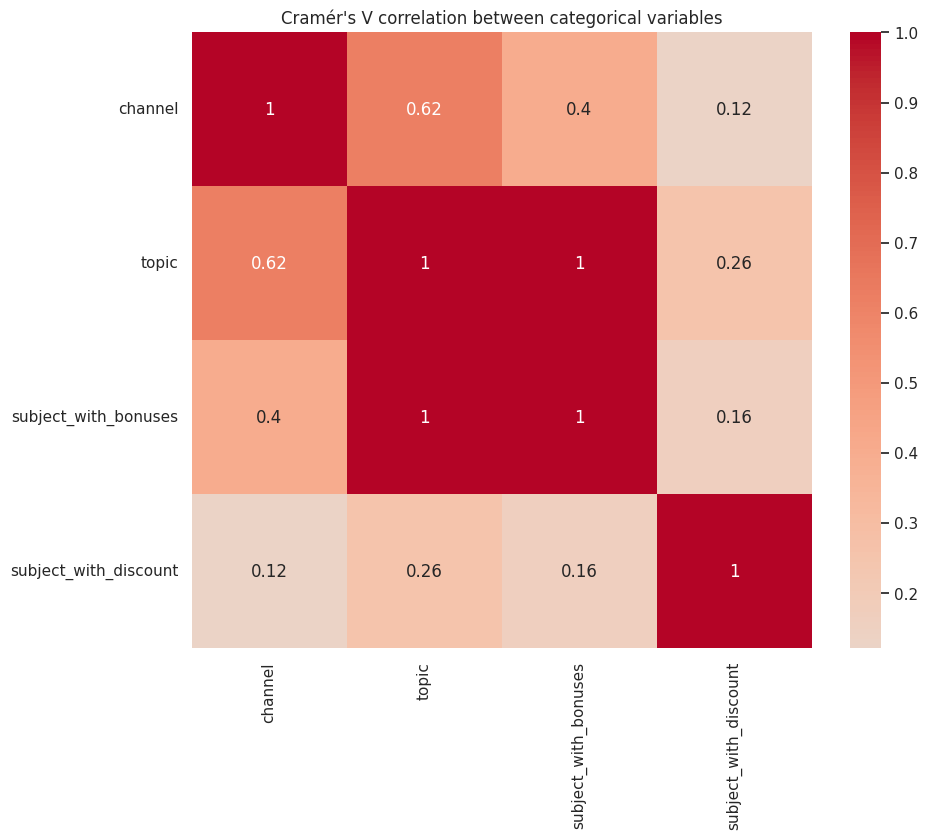

In [28]:
# The heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Cramér's V correlation between categorical variables")
plt.show()

### 7.3 Handling low-frequency combinations

We calculated Cramér's V to analyze the correlation between categorical features. However, low-frequency combinations in the dataset can distort the correlation results. For example, a single occurrence of `sale out` with `subject_with_bonuses=True` can skew the analysis. We will filter out such rare combinations.

We begin by inspecting the distribution of combinations of `subject_with_bonuses` and `topic` to check for any low-frequency combinations. By identifying these rare occurrences, we can make informed decisions about filtering them out before computing correlations.

In [29]:
combo_count = campaigns_df.groupby(['subject_with_bonuses', 'topic']).size()
print(combo_count)

subject_with_bonuses  topic               
False                 event                    63
                      offer after purchase    316
                      sale out                766
                      welcome campaign         23
True                  happy birthday          332
                      leave review            287
                      sale out                  1
dtype: int64


Next, we extend this check to all categorical variables of interest. We calculate the frequency of all combinations for our selected categorical columns (`channel`, `topic`, `subject_with_bonuses`, and `subject_with_discount`). By doing so, we ensure that any rare combinations between these variables are identified and excluded from further analysis, thereby preventing them from skewing the correlation results.

In [30]:
# List of categorical columns to check for combo frequency
categorical_cols = ['channel', 'topic', 'subject_with_bonuses', 'subject_with_discount']

# Perform combo count for all combinations of the selected categorical variables
for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 != col2:
            combo_count = campaigns_df.groupby([col1, col2]).size()
            print(f"Combination of {col1} and {col2}:")
            print(combo_count[combo_count < 5])  # Display low-frequency combinations

Combination of channel and topic:
channel      topic           
mobile_push  welcome campaign    2
dtype: int64
Combination of channel and subject_with_bonuses:
channel  subject_with_bonuses
email    True                    1
dtype: int64
Combination of channel and subject_with_discount:
Series([], dtype: int64)
Combination of topic and channel:
topic             channel    
welcome campaign  mobile_push    2
dtype: int64
Combination of topic and subject_with_bonuses:
topic     subject_with_bonuses
sale out  True                    1
dtype: int64
Combination of topic and subject_with_discount:
topic  subject_with_discount
event  True                     1
dtype: int64
Combination of subject_with_bonuses and channel:
subject_with_bonuses  channel
True                  email      1
dtype: int64
Combination of subject_with_bonuses and topic:
subject_with_bonuses  topic   
True                  sale out    1
dtype: int64
Combination of subject_with_bonuses and subject_with_discount:
Series

We have identified several low-frequency combinations between categorical variables. These rare combinations can distort the correlation calculation, particularly when using methods like Cramér's V. We will filter out combinations that appear fewer than 5 times in the dataset.

By doing this, we reduce the noise from outliers and improve the accuracy of the insights we gain from the correlation analysis.

In [31]:
# List of categorical columns to check for combo frequency
categorical_cols = ['channel', 'topic', 'subject_with_bonuses', 'subject_with_discount']

# Creating a list to hold the filtered data
filtered_df_list = []

# Looping over each pair of categorical columns and filter out low-frequency combinations
for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 != col2:
            # Group by the two columns and filter combinations that occur less than 5 times
            filtered_df_pair = campaigns_df.groupby([col1, col2]).filter(lambda x: len(x) >= 5)
            # Append the filtered results for this pair to the list
            filtered_df_list.append(filtered_df_pair)
            # Preview unique combinations after filtering
            print(f"Filtered combinations of {col1} and {col2}:")
            print(filtered_df_pair[[col1, col2]].drop_duplicates())

# Combining all filtered DataFrames into one
filtered_df = pd.concat(filtered_df_list).drop_duplicates()

Filtered combinations of channel and topic:
         channel                 topic
0    mobile_push              sale out
7          email              sale out
17         email                 event
18   mobile_push                 event
164  mobile_push  offer after purchase
314  mobile_push        happy birthday
687  mobile_push          leave review
692        email      welcome campaign
Filtered combinations of channel and subject_with_bonuses:
         channel  subject_with_bonuses
0    mobile_push                 False
7          email                 False
314  mobile_push                  True
Filtered combinations of channel and subject_with_discount:
        channel  subject_with_discount
0   mobile_push                  False
7         email                  False
17        email                   True
36  mobile_push                   True
Filtered combinations of topic and channel:
                    topic      channel
0                sale out  mobile_push
7            

After filtering out low-frequency combinations, we are now left with more consistent and meaningful data. This will allow us to recalculate the Cramér’s V matrix with improved accuracy.

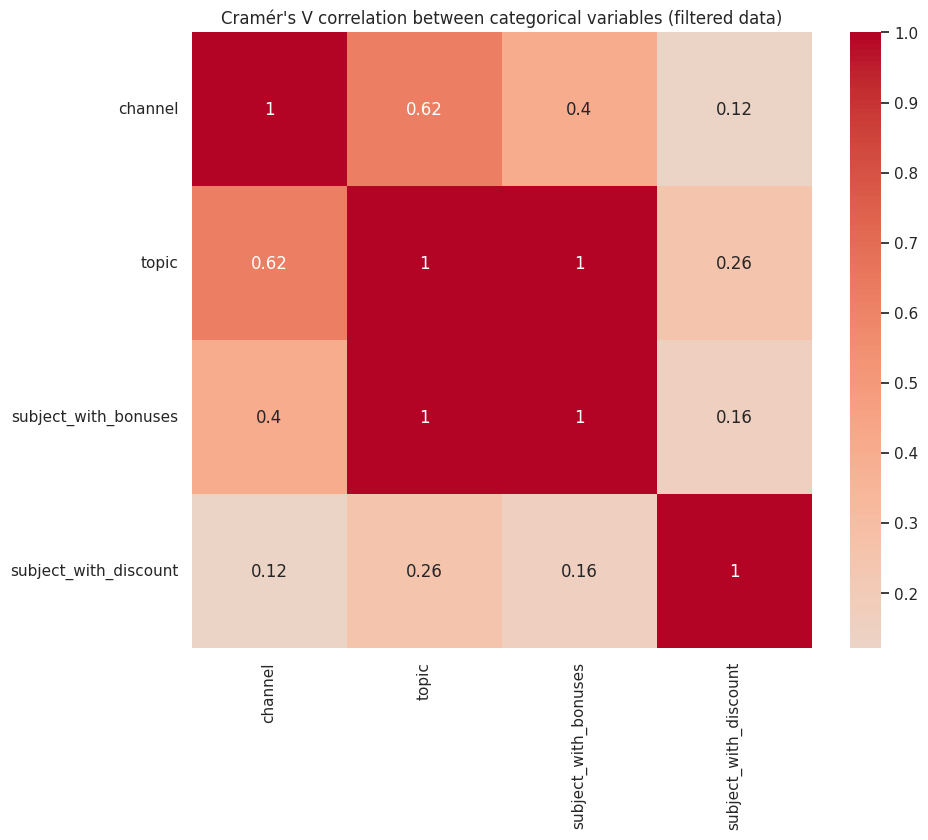

In [32]:
# List of categorical columns to check for Cramér's V calculation
categorical_cols_filtered = ['channel', 'topic', 'subject_with_bonuses', 'subject_with_discount']

# Recalculating Cramér's V based on the filtered data
filtered_cramers_v_matrix = pd.DataFrame(index=categorical_cols_filtered, columns=categorical_cols_filtered)

for col1 in categorical_cols_filtered:
    for col2 in categorical_cols_filtered:
        if col1 == col2:
            filtered_cramers_v_matrix.loc[col1, col2] = 1  # Diagonal values should be 1
        else:
            filtered_cramers_v_matrix.loc[col1, col2] = cramers_v(filtered_df[col1], filtered_df[col2])

# Convert the matrix to float and handle missing values
filtered_cramers_v_matrix = filtered_cramers_v_matrix.astype(float).fillna(0)

# Generate heatmap for the filtered data
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_cramers_v_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Cramér's V correlation between categorical variables (filtered data)")
plt.show()

We performed a frequency check.

However, upon recalculating Cramér's V with the filtered dataset, we found that the resulting heatmap remained virtually identical to the original. This indicates that the low-frequency combinations were not significantly influencing the overall correlation between the categorical variables. As a result, we can conclude that these rare combinations did not affect the integrity of the correlation analysis.

##### Conclusions:

- Correlation between campaign channel and topic; a notable correlation (0.62) between the type of channel (e.g., email, mobile) and the topic of the campaign. This suggests that specific campaign topics are more often promoted through certain channels. For example, promotional sales may be pushed more via mobile, while review requests might be sent through email.

- Campaigns that offer bonuses are strongly tied to specific topics, like "Happy Birthday" and "Leave Review." This indicates that bonuses are primarily used in these types of campaigns, likely because they are effective in engaging customers during those moments.

- No strong link with discounts. There's a weaker correlation (0.16) between campaigns with discounts and topics, meaning discounts are more evenly spread across different campaign types and aren't concentrated in specific topics.

##### Key takeaways for action:
- Leverage bonuses in "Happy Birthday" and "Leave Review" campaigns as they are showing effectiveness.
- Align channels with campaign types: If certain topics perform better on specific channels, it’s worth refining channel strategies to maximize engagement.
- Revisit discount strategy: Since discounts aren't heavily tied to specific topics, there may be room to optimize where and how discounts are applied.

## 8. Conclusion

- **Data structure**: The datasets were generally well-structured, though there were significant missing values in certain columns, particularly in the `Messages` dataset. These missing values often represented meaningful events (e.g., actions like purchases or clicks that did not occur).

- **Handling missing data**: Columns with over 90% missing data were removed (e.g., `ab_test` in the `Campaigns` dataset). Action-related columns in the `Messages` dataset were retained because missing values represented non-action events (such as no purchase made), providing meaningful insights for future analysis.

- **Consistency across datasets**: We identified inconsistencies between `campaign_id` and `client_id` across the `Messages` and `Campaigns` datasets. Rows with missing `campaign_id` were excluded, while missing `client_id` entries were retained and flagged for further analysis of non-converting customers.

- **Campaign effectiveness**: A significant portion of campaigns (approximately 85%) were flagged as successful, indicating that a majority of the marketing efforts resulted in conversions. However, campaigns with 100% missing `client_id` provided insights into ineffective strategies that did not drive customer engagement.

- **Correlations**: Strong correlations were observed between certain numerical features like `total_count` and `is_successful`, indicating that larger campaigns tend to be more successful. Categorical correlations using Cramér’s V showed strong associations between `channel` and `topic`, suggesting that certain types of campaigns are more effective on specific platforms (e.g., mobile push campaigns for promotional sales).

- **Bonuses and campaign performance**: Campaigns offering bonuses (e.g., for events like “Happy Birthday” and “Leave Review”) were found to be more effective, while discounts showed weaker correlations, suggesting they may be more evenly spread across different campaign types and less impactful.

- **Optimization opportunities**: The analysis highlighted potential areas for optimization, such as:
  - Leveraging bonuses in campaigns like “Happy Birthday” and “Leave Review,” as these seem to drive higher customer engagement.
  - Refining channel strategies to align better with campaign topics, ensuring that the right channels are used for each type of campaign (e.g., mobile push for sales).
  - Revisiting discount strategies, as discounts were not strongly linked to specific topics and could benefit from more targeted use.
